## Is it a bird?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    %pip install -Uqq fastai

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

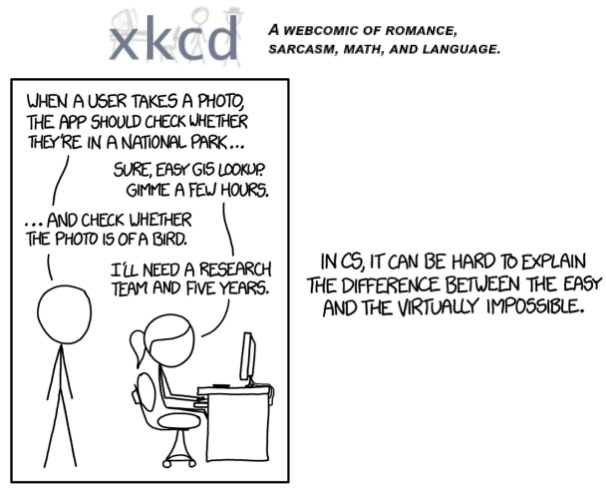

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [ ]:
# Skip this cell if you already have duckduckgo_search installed
%pip install fastbook

define ten classes using fastai module

In [3]:
from fastai.vision.all import *

classes = ['penguin', 'kangaroo', 'octopus', 'peacock', 'cheetah', 'orangutan', 'flamingo', 'koala', 'crocodile', 'gorilla']


use the fastbook library to scrape sample images off the web to download 10 images for each class. 

In [4]:
from fastbook import *
from time import sleep

path = Path('animal_data')

for animal in classes:
    dest = (path/animal)
    dest.mkdir(exist_ok=True, parents=True)

    # Download 200 images for each class
    print(f"Downloading images of {animal}...")
    download_images(dest, urls=search_images_ddg(f'{animal} animal', max_images=200))
    sleep(10)  # Pause between searches to avoid over-loading server


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [5]:
from fastai.vision.utils import verify_images
from fastbook import *

classes = ['penguin', 'kangaroo', 'octopus', 'peacock', 'cheetah', 'orangutan', 'flamingo', 'koala', 'crocodile', 'gorilla']
path = Path('animal_data')

for animal in classes:
    dest = (path/animal)
    
    # Verify images
    failed_images = []
    for img in get_image_files(dest):
        try:
            img = PILImage.create(img)
            img.verify()
        except Exception as e:
            print(f"Failed to verify image: {img}")
            failed_images.append(img)
    
    # Remove failed images
    for img in failed_images:
        img.unlink()
    
    print(f"Removed {len(failed_images)} failed images of {animal}")


Failed to verify image: animal_data\penguin\0db045a9-de3b-4643-a269-ff619a2f5477.jpg
Failed to verify image: animal_data\penguin\38b47dcc-fb52-4835-8fa2-9adc9ada99c6.png
Removed 2 failed images of penguin
Failed to verify image: animal_data\kangaroo\0bb7802c-a123-43a6-b324-9cb29bf42eeb.jpg
Failed to verify image: animal_data\kangaroo\579796c2-d0ee-491d-a6ab-dd781cf02c91.jpg
Failed to verify image: animal_data\kangaroo\a0ddb5a2-9fdf-40ab-be91-e5c0516cd304.jpg
Failed to verify image: animal_data\kangaroo\a411ee36-df6d-456f-b969-a09a61e3d4a9.jpg
Failed to verify image: animal_data\kangaroo\a431274d-9578-461e-b5df-9e8c5dc16531.jpg
Failed to verify image: animal_data\kangaroo\ac61f7ee-f92b-4b16-892f-4817d6f3b678.jpg
Failed to verify image: animal_data\kangaroo\e590b552-e4de-4bad-96ed-a40dcd0933f7.jpg
Removed 7 failed images of kangaroo
Failed to verify image: animal_data\octopus\6db2b928-39ff-4226-9257-7f5fea0f4200.jpg
Failed to verify image: animal_data\octopus\7d487683-8641-41b3-b70d-ac58

found that some image file has the suffix with "jpg!d" , which need to be changed to the "jpg"

In [7]:
import os

# Define the root directory
root_directory = "animal_data"

# Loop through the subdirectories
for subdir in os.listdir(root_directory):
    # Get the full path of the subdirectory
    subdir_path = os.path.join(root_directory, subdir)
    
    # Check if the path is a directory
    if os.path.isdir(subdir_path):
        # Loop through the files in the subdirectory
        for file in os.listdir(subdir_path):
            # Get the full path of the file
            file_path = os.path.join(subdir_path, file)
            
            # Check if the file is an image file and ends with "jpg!d"
            if os.path.isfile(file_path) and file.lower().endswith("jpg!d"):
                # Generate the new file name
                new_file_name = file[:-5] + "jpg"
                
                # Generate the full path of the new file
                new_file_path = os.path.join(subdir_path, new_file_name)
                
                # Rename the file
                os.rename(file_path, new_file_path)
                print(f"Renamed {file} to {new_file_name}")


To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

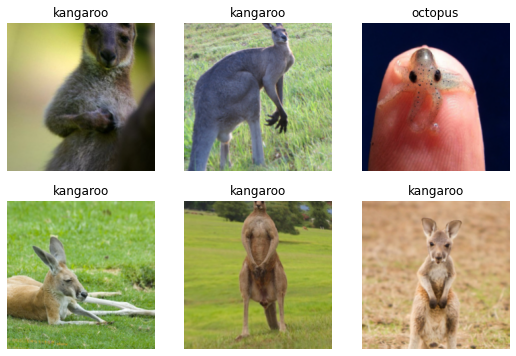

In [8]:
path = Path('animal_data')

# Define transformation and augmentation options
item_tfms = Resize(224)
batch_tfms = aug_transforms()

# Create a DataBlock for the animal classification task
animal_data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_items=get_image_files,
                        splitter=RandomSplitter(valid_pct=0.2, seed=42),
                        get_y=parent_label,
                        item_tfms=item_tfms,
                        batch_tfms=batch_tfms)

# Create DataLoaders from the DataBlock
dls = animal_data.dataloaders(path)

# Show sample images from the DataLoaders
dls.show_batch(max_n=6)


Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

D:\program\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\program\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.395652,0.068772,0.021858,01:45


epoch,train_loss,valid_loss,error_rate,time
0,0.100520,0.047378,0.010929,01:44
1,0.072925,0.049903,0.008197,01:42
2,0.052167,0.058038,0.010929,01:44
3,0.036507,0.054899,0.008197,01:45


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

# t-SNE Visualization:
* t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-parametric dimensionality reduction technique in which high-dimensional data (n features) is mapped into low-dimensional data (typically 2 or 3 features) while preserving relationship among the data points of original high-dimensional data.

* A t-SNE algorithm is an unsupervised machine learning algorithm primarily used for visualizing. Using [scatter plots]((scatter-plot-matplotlib.html), low-dimensional data generated with t-SNE can be visualized easily.

* t-SNE is a probabilistic model, and it models the probability of neighboring points such that similar samples will be placed together and dissimilar samples at greater distances. Hence, t-SNE is helpful in understanding the data structure and distribution characteristics of the high-dimensional datasets.

* In this code, t-SNE analysis and visualization can be performed using the TSNE() function from scikit-learn and bioinfokit packages. Interpreting such high-dimensional non-linear data would be impractical without transforming them into low-dimensional data. Using dimension reduction techniques such as t-SNE, high-dimensional datasets can be reduced into two-dimensional space for visualization and understanding biologically meaningful clusters present in high-dimensional datasets. 

# Confusion Matrix: 
* It is a table that is used in classification problems to assess where errors in the model were made.The rows represent the actual classes the outcomes should have been. While the columns represent the predictions we have made. Using this table it is easy to see which predictions are wrong.
* A confusion matrix provides a detailed view of the model's performance by showing the number of correct and incorrect predictions for each class. we can generate a confusion matrix using the plot_confusion_matrix() function.

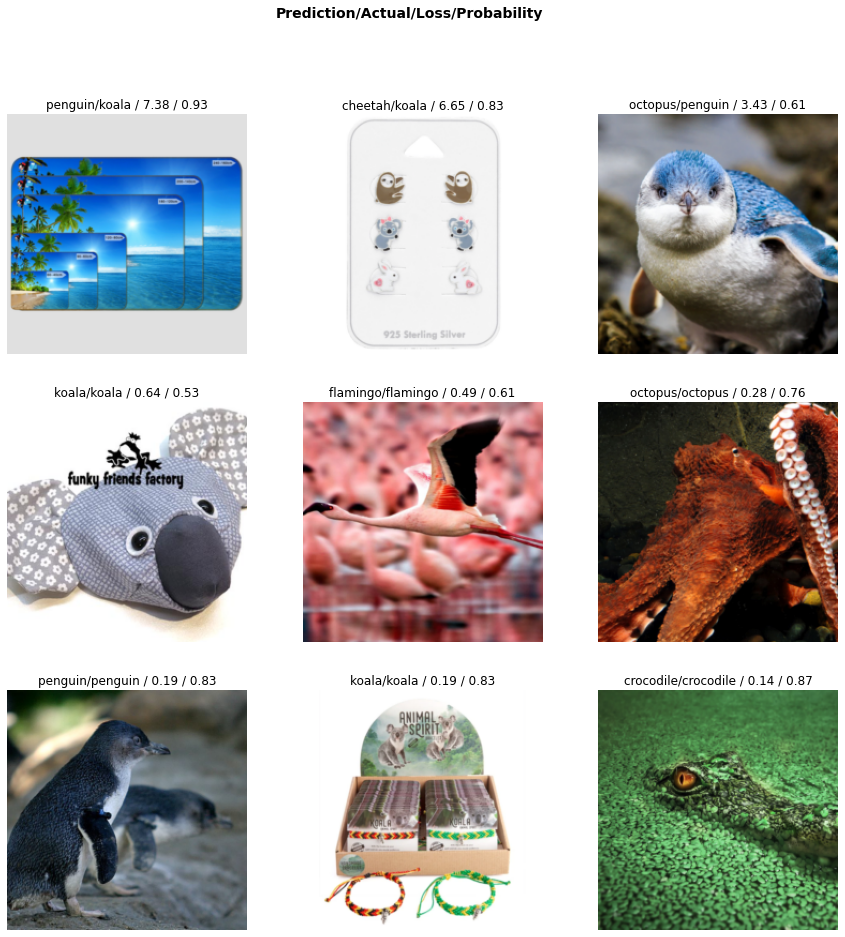

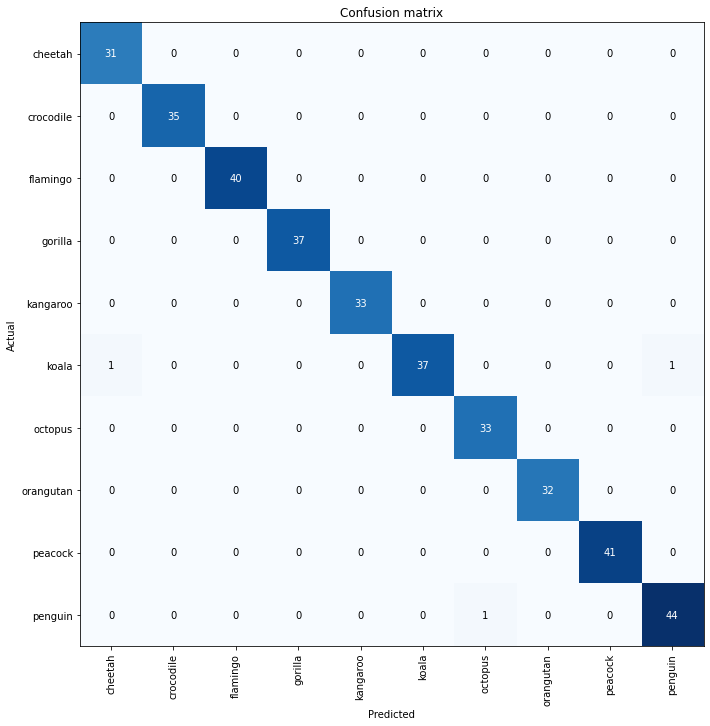

In [10]:
# Generate t-SNE plot
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))
interp.plot_confusion_matrix(figsize=(10,10))

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.